### Convex surface detection

In [1]:
import torch
from PIL import Image 
import numpy as np

import matplotlib.pyplot as plt
import math

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import warnings
warnings.filterwarnings('ignore')

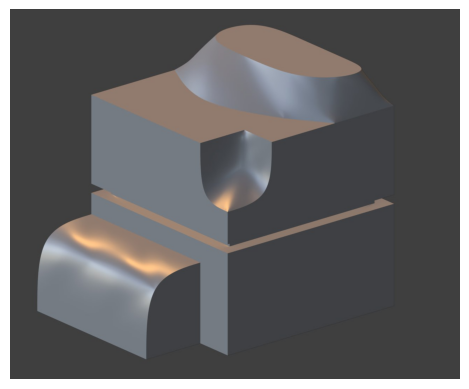

In [2]:
input_img = Image.open('../data/photo_5395381481544738292_y.jpg')
plt.imshow(input_img)
plt.axis('off')
plt.show()

The proposed framework for segmentation is Segment Anything https://github.com/facebookresearch/segment-anything

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = '<path_to_>/sam_vit_h_4b8939.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(np.array(input_img))

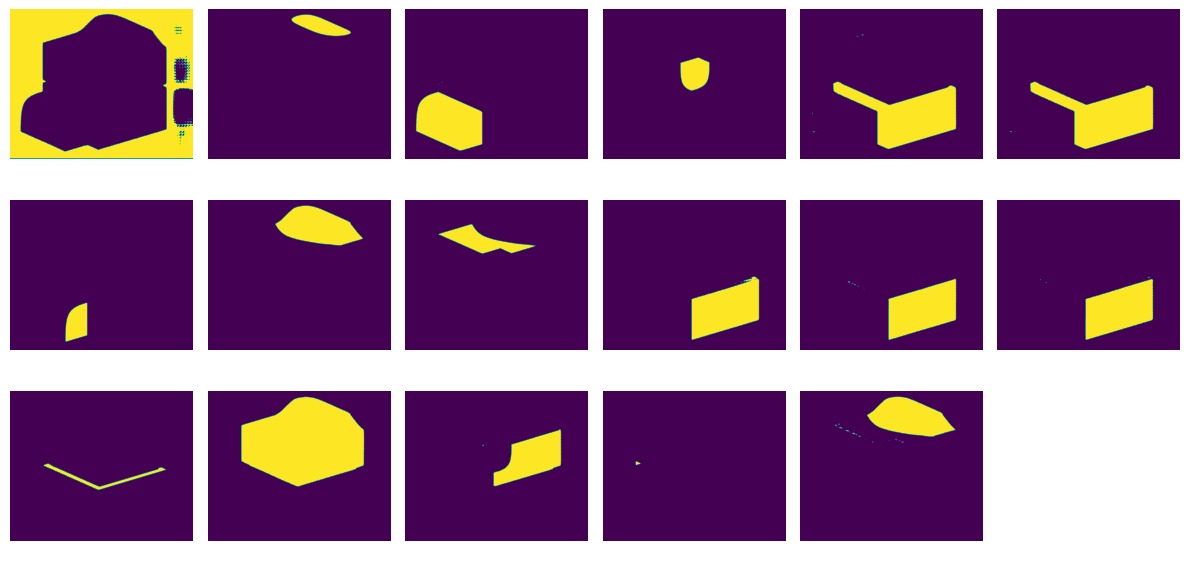

In [4]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
index = 0
for i in range(rows):
    for j in range(cols):
        if index < n:
            axes[i][j].imshow(masks[index]['segmentation'][:,:, None])
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
np.random.seed(0)
def show_anns(anns):
    colors = []
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        colors.append(color_mask)
        img[m] = color_mask
    ax.imshow(img)
    return img, colors

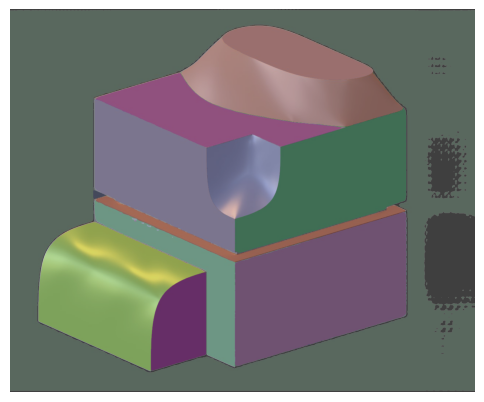

In [6]:
plt.figure(figsize=(6,12))
plt.imshow(np.array(input_img))
colored_img, colors = show_anns(masks)
plt.axis('off')
plt.show() 

Superimposing masks on top of one another to obtain non-overlapping unique mask

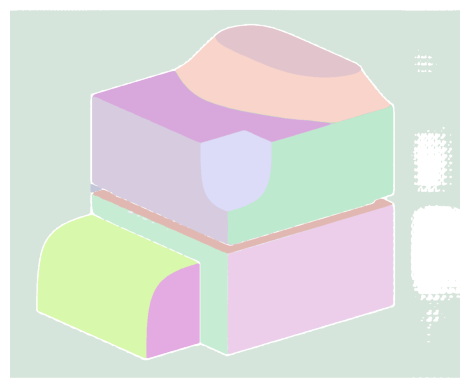

Number of colors 17


In [7]:
plt.imshow(colored_img)
plt.axis('off')
plt.show()
print("Number of colors", len(colors))

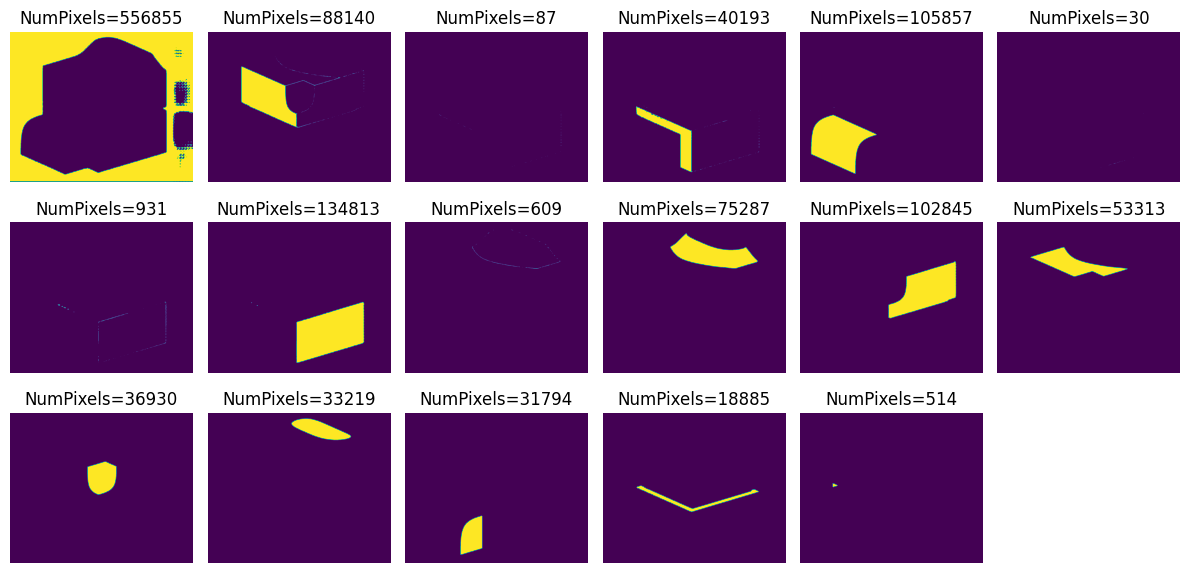

In [8]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
index = 0
for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            new_mask = (colored_img == colors[index]).all(axis=-1)
            axes[i][j].imshow(new_mask)
            axes[i][j].set_title(f'NumPixels={np.sum(new_mask)}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

Masks with a pixel count of less than 1 % of the total number of image pixels will not be considered

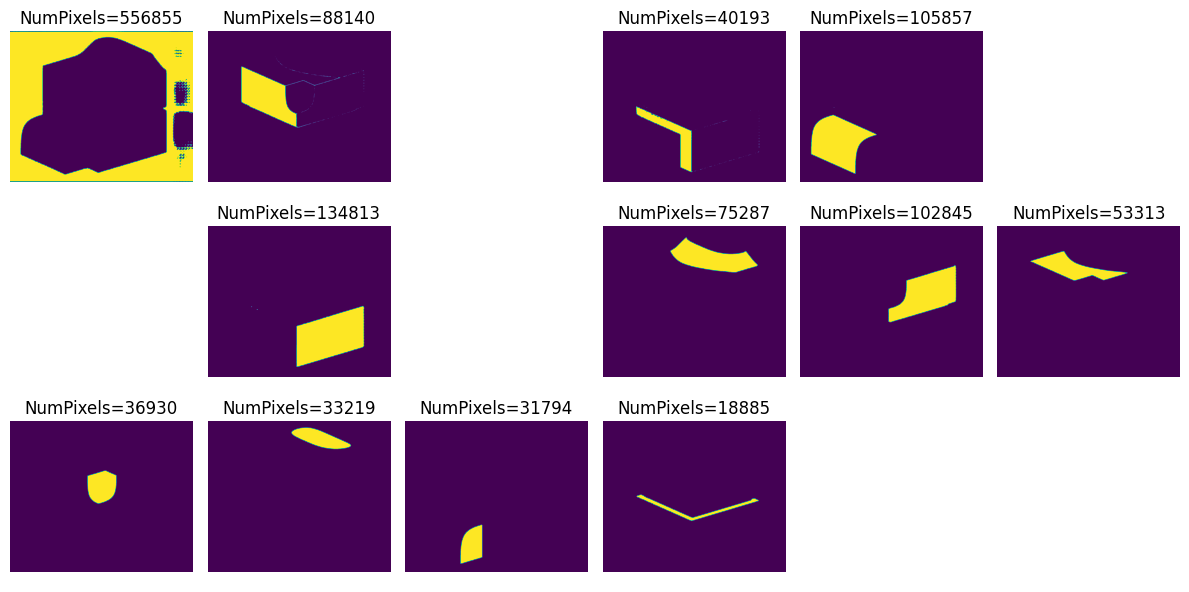

In [9]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
index = 0

new_masks_list = []
threshold = 0.01

for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            new_mask = (colored_img == colors[index]).all(axis=-1)
            if np.sum(new_mask) >= colored_img.shape[0] * colored_img.shape[1] * threshold:
                new_masks_list.append(new_mask)
                axes[i][j].imshow(new_mask)
                axes[i][j].set_title(f'NumPixels={np.sum(new_mask)}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

Now let's analyze how colors change within each mask. The proposed idea is that, for convex surfaces that we want to segment, the colors will vary more than for flat surfaces. We can attempt to detect color changes by calculating the color dispersion for each mask

In [10]:
def masked_mean(image, mask):
    return (image * mask).sum() / mask.sum()

def masked_variance(image, mask):
    diff = image - masked_mean(image, mask)
    return (diff**2 * mask).sum() / mask.sum()

def masked_std(image, mask):
    return np.sqrt(masked_variance(image, mask))

In [11]:
def func(mask_idx, new_masks_list, input_img):
    
    mask = new_masks_list[mask_idx]
    image = np.array(input_img).copy()
    
    image[:,:,0] = image[:,:,0]*mask
    image[:,:,1] = image[:,:,1]*mask
    image[:,:,2] = image[:,:,2]*mask

    masked_variance_list = []
    
    for i in range(3):
        masked_variance_list.append(masked_variance(image[:, :, i], mask))

    return image, sum(masked_variance_list)

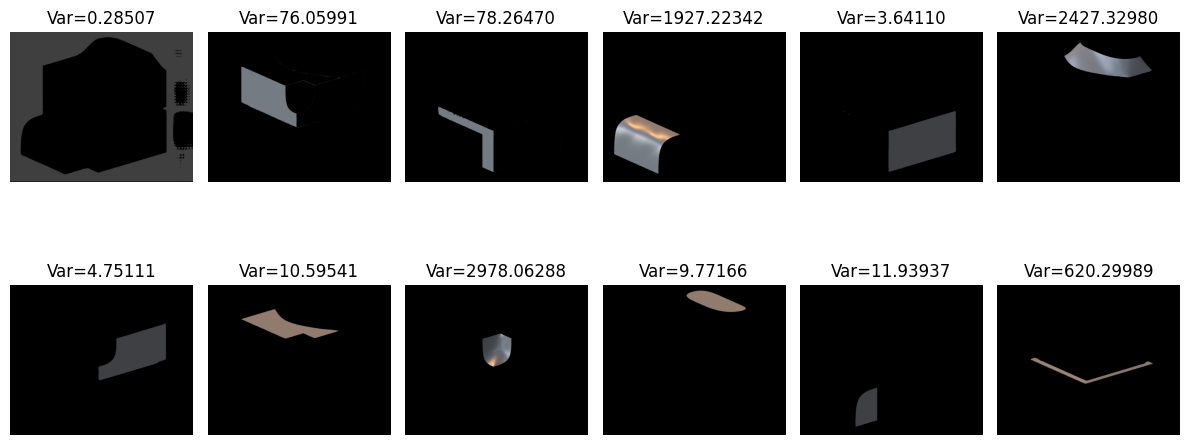

In [12]:
n = len(new_masks_list)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
index = 0

var_list = []
for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            img, var = func(index, new_masks_list, input_img)
            var_list.append(var)
            axes[i][j].imshow(img)
            axes[i][j].set_title(f'Var={var:.5f}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [13]:
print('Min/Max color variance inside each mask:', min(var_list), max(var_list))

Min/Max color variance inside each mask: 0.285066985216999 2978.0628796071987


We can determine the threshold for detecting convex surfaces

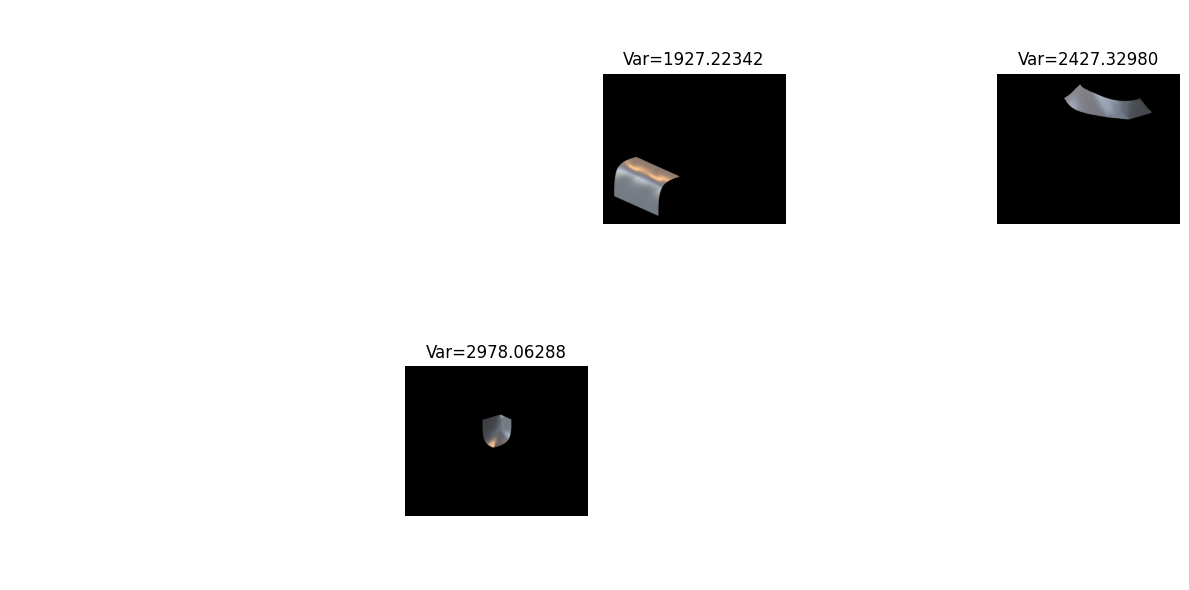

In [14]:
n = len(new_masks_list)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
index = 0

threshold = 0.3
final_masks = []
for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            img, var = func(index, new_masks_list, input_img)
            if var > max(var_list) * threshold:
                final_masks.append(new_masks_list[index])
                axes[i][j].imshow(img)
                axes[i][j].set_title(f'Var={var:.5f}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

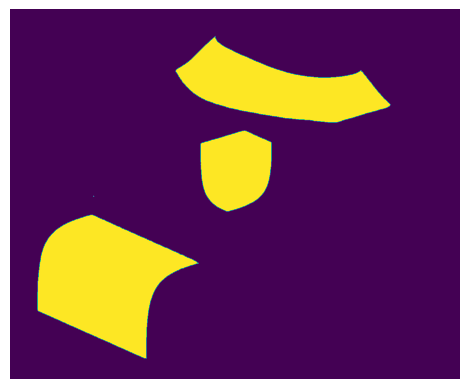

In [15]:
plt.imshow(sum(final_masks))
plt.axis('off')
plt.show()

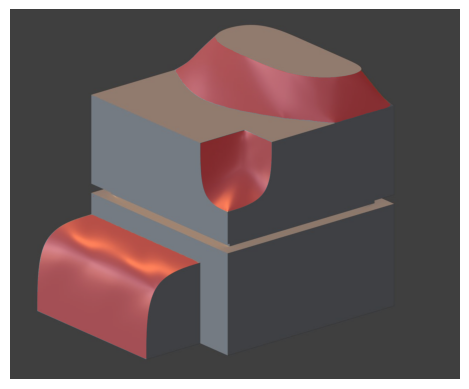

In [17]:
mask = sum(final_masks)
image = np.array(input_img).copy()
alpha = 0.35
image = image.astype(int).astype(float)
image[mask > 0] *= (1 - alpha)
image[mask > 0] += alpha * np.array([255, 0, 0])
image = image.astype(int).astype(np.uint8)

plt.imshow(image)
plt.axis('off')
plt.show()